# Enhancing Image Super-Resolution with Generative Adversarial Networks (GANs)

## Data Source
In this project, we utilize the DIV2K Realistic Mild x4 dataset, which is part of the DIV2K collection specifically designed for image super-resolution tasks. This dataset consists of two main components:
- **Low-Resolution (LR) Images**: These images have undergone a "realistic mild" degradation process and are stored in the `DIV2K_realisticMild/` directory. This degradation simulates mild degradation like slight blurring and noise and represents common real-world low-resolution scenarios.
- **High-Resolution (HR) Images**: These are the original high-quality images that we will use as ground truth, and are located in the `DIV2K_highRes/` directory.


The datasets can be downloaded from the official DIV2K website at [https://data.vision.ee.ethz.ch/cvl/DIV2K/](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

For this project, we specifically downloaded the Realistic Mild x4 data to ensure that our low-resolution images are appropriate for the image super-resolution task.

In [7]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [9]:
lr_path = '/content/drive/MyDrive/DIV2K_train_val_test_LR_mild/'
hr_path = '/content/drive/MyDrive/DIV2K_HR/'

lr_images = os.listdir(lr_path)
hr_images = os.listdir(hr_path)

total_images = len(lr_images)
total_size = 0
unique_dimensions = set()
min_dimension = (float('inf'), float('inf'))
max_dimension = (0, 0)

for img_name in lr_images:
    img_path = os.path.join(lr_path, img_name)
    img = Image.open(img_path)
    total_size += os.path.getsize(img_path)
    dimensions = img.size
    unique_dimensions.add(dimensions)
    min_dimension = min(min_dimension, dimensions)
    max_dimension = max(max_dimension, dimensions)

total_size_MB = total_size / (1024 * 1024)

print(f"----{lr_path}----")
print(f"Total Image Count: {total_images}")
print(f"Size: {total_size_MB:.2f} MB")
print(f"Unique Dimensions: {len(unique_dimensions)}")
print(f"Min Dimension: {min_dimension}")
print(f"Max Dimension: {max_dimension}")

----/content/drive/MyDrive/DIV2K_train_val_test_LR_mild/----
Total Image Count: 900
Size: 296.50 MB
Unique Dimensions: 101
Min Dimension: (279, 510)
Max Dimension: (510, 510)


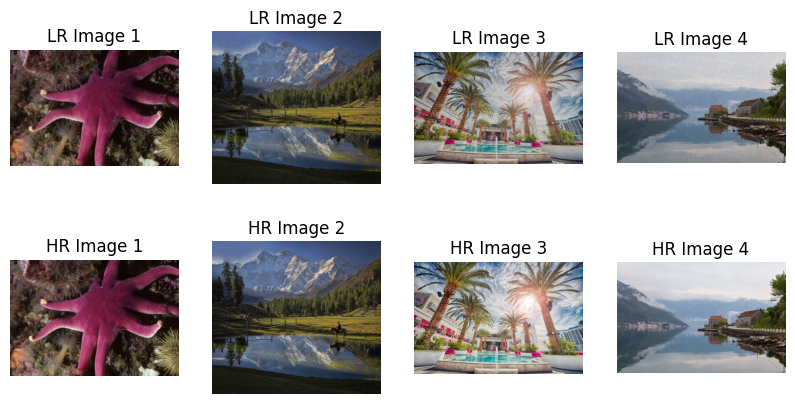

In [10]:
def display_samples(lr_path, hr_path, lr_images, hr_images, num_samples=4):
    plt.figure(figsize=(10, 5))
    #We have to sort the images first
    lr_images = sorted(os.listdir(lr_path))
    hr_images = sorted(os.listdir(hr_path))

    for i in range(num_samples):
        lr_img = Image.open(os.path.join(lr_path, lr_images[i]))
        hr_img = Image.open(os.path.join(hr_path, hr_images[i]))

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(lr_img)
        plt.title(f"LR Image {i + 1}")
        plt.axis('off')

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(hr_img)
        plt.title(f"HR Image {i + 1}")
        plt.axis('off')

    plt.show()

display_samples(lr_path, hr_path, lr_images, hr_images)

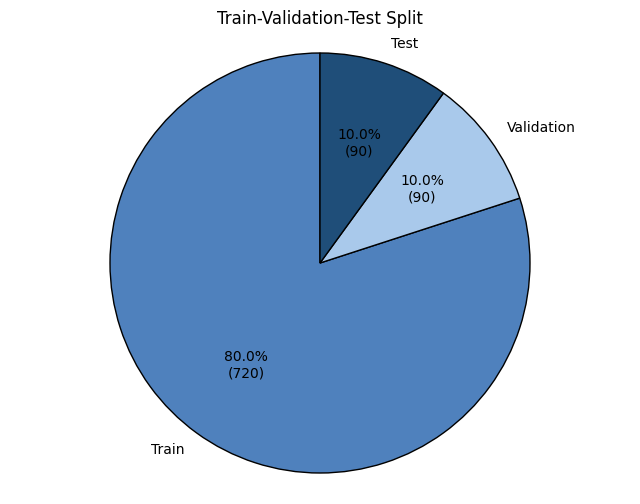

In [11]:
#split data %(80-10-10)
lr_train, lr_temp, hr_train, hr_temp = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)
lr_val, lr_test, hr_val, hr_test = train_test_split(lr_temp, hr_temp, test_size=0.5, random_state=42)

num_train = len(lr_train)
num_val = len(lr_val)
num_test = len(lr_test)

labels = ['Train', 'Validation', 'Test']
sizes = [num_train, num_val, num_test]
colors = ['#4F81BD', '#A9C9EB', '#1F4E79']

def func(pct, all_vals):
    absolute = int(pct/100.*sum(all_vals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct=lambda pct: func(pct, sizes), colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

plt.axis('equal')
plt.title('Train-Validation-Test Split')
plt.show()


## Preprocessing

In this step, we prepared our images for the project by resizing the low-resolution images to 64x64 and high-resolution ground truth images to 256x256 pixels. We also normalized the pixel values of both image types, adjusting them to a range between 0 and 1.

This preprocessing ensures that our images are in the correct format and size, making them suitable for training the GAN model effectively.

In [12]:
def load_and_preprocess_images(image_names, lr_path, hr_path, lr_size=(64, 64), hr_size=(256, 256)):
    lr_images = []
    hr_images = []

    for img_name in image_names:
        # Load and resize LR image to 64x64
        lr_img = Image.open(os.path.join(lr_path, img_name)).resize(lr_size)
        # Normalize LR image
        lr_img = np.array(lr_img) / 255.0

        # Get the correct HR image filename
        base_name = img_name.split('x')[0]  # Assuming base name is the same
        hr_img_name = f"{base_name}.png"  # Modify to match the actual HR image naming convention

        # Load and resize HR image to 256x256
        hr_img = Image.open(os.path.join(hr_path, hr_img_name)).resize(hr_size)
        # Normalize HR image
        hr_img = np.array(hr_img) / 255.0

        # Append the images to the lists
        lr_images.append(lr_img)
        hr_images.append(hr_img)

    # Convert lists to numpy arrays
    lr_images = np.array(lr_images)
    hr_images = np.array(hr_images)

    return lr_images, hr_images

In [13]:
#prepare data
lr_train_images, hr_train_images = load_and_preprocess_images(lr_train, lr_path, hr_path)
lr_val_images, hr_val_images = load_and_preprocess_images(lr_val, lr_path, hr_path)
lr_test_images, hr_test_images = load_and_preprocess_images(lr_test, lr_path, hr_path)

print(f"Training LR shape: {lr_train_images.shape}, HR shape: {hr_train_images.shape}")
print(f"Validation LR shape: {lr_val_images.shape}, HR shape: {hr_val_images.shape}")
print(f"Test LR shape: {lr_test_images.shape}, HR shape: {hr_test_images.shape}")

Training LR shape: (720, 64, 64, 3), HR shape: (720, 256, 256, 3)
Validation LR shape: (90, 64, 64, 3), HR shape: (90, 256, 256, 3)
Test LR shape: (90, 64, 64, 3), HR shape: (90, 256, 256, 3)


### Image Upscaling and Evaluation

In this step, we upscale the low-resolution images using two interpolation methods: bilinear and bicubic. The low-resolution images are resized to match the size of the high-resolution ground truth images. We also compute the **PSNR** and **SSIM** metrics to evaluate the quality of the upscaled images.

This process helps in comparing the performance of different interpolation techniques and provides a baseline for evaluating the image quality before applying more advanced models like ESRGAN.



In [14]:
def upscale_images(lr_images, hr_images, lr_size=(64, 64), hr_size=(256, 256)):
    bilinear_images = []
    bicubic_images = []
    psnr_bilinear, ssim_bilinear = [], []
    psnr_bicubic, ssim_bicubic = [], []

    for lr, hr in zip(lr_images, hr_images):
        bilinear_img = cv2.resize(lr, (hr_size[1], hr_size[0]), interpolation=cv2.INTER_LINEAR)
        bicubic_img = cv2.resize(lr, (hr_size[1], hr_size[0]), interpolation=cv2.INTER_CUBIC)

        bilinear_images.append(bilinear_img)
        bicubic_images.append(bicubic_img)

        psnr_bilinear.append(psnr(hr, bilinear_img))
        ssim_bilinear.append(ssim(hr, bilinear_img, multichannel=True, win_size=3, data_range=1.0))

        psnr_bicubic.append(psnr(hr, bicubic_img))
        ssim_bicubic.append(ssim(hr, bicubic_img, multichannel=True, win_size=3, data_range=1.0))

    return bilinear_images, bicubic_images, psnr_bilinear, ssim_bilinear, psnr_bicubic, ssim_bicubic

bilinear_train, bicubic_train, psnr_bilinear_train, ssim_bilinear_train, psnr_bicubic_train, ssim_bicubic_train = upscale_images(
    lr_train_images, hr_train_images)


### ESRGAN Model Architecture and Training

In this step, we build and train a simple ESRGAN inspired model that consists of three main components:

1. **Generator Model**: The generator is built using residual blocks (RRDB), which help in capturing intricate features. It performs upsampling with pixel shuffle to increase image resolution and generate high-quality output images.
  
2. **Discriminator Model**: The discriminator is designed to distinguish between real and fake high-resolution images. It uses convolutional layers and batch normalization to extract features, followed by dense layers for final classification.

3. **Perceptual Loss (VGG19)**: We use a VGG19 model, which is pre-trained on ImageNet, to calculate perceptual loss. This helps the generator produce images that are perceptually closer to the high-resolution ground truth.

The training process involves alternating between training the discriminator and the generator. The discriminator is trained to differentiate between real and fake images, while the generator is trained to improve its ability to generate realistic images, guided by both the adversarial loss and perceptual loss.


In [20]:
#generator model
def build_generator():
    inputs = layers.Input(shape=(64, 64, 3))

    #initial conv block
    x = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    initial_block = x

    #residual blocks
    for _ in range(16):  # More layers for better feature extraction
        x = residual_block(x)

    #skip connect
    x = layers.Add()([x, initial_block])

    #upsampling layers
    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)  # Upscale by 2x
    x = layers.PReLU(shared_axes=[1, 2])(x)

    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)  # Upscale by 2x
    x = layers.PReLU(shared_axes=[1, 2])(x)

    #output layer
    outputs = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

def residual_block(x):
    residual = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    residual = layers.BatchNormalization()(residual)  # Added batch normalization
    residual = layers.PReLU(shared_axes=[1, 2])(residual)
    residual = layers.Conv2D(64, kernel_size=3, padding='same')(residual)
    residual = layers.BatchNormalization()(residual)  # Added batch normalization
    return layers.Add()([x, residual])

#discriminator model
def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))

    #conv layers
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    for filters in [128, 256, 512]:
        x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    #dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

#perp loss
def build_vgg_loss():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    vgg.trainable = False
    model = models.Model(vgg.input, vgg.get_layer('block5_conv4').output)
    return model

def build_gan(generator, discriminator, vgg):
    discriminator.trainable = False

    gan_input = layers.Input(shape=(64, 64, 3))
    gen_out = generator(gan_input)
    gan_output = discriminator(gen_out)

    # Perceptual loss using VGG19 features
    content_loss = vgg(gen_out)
    gan = models.Model(gan_input, [gan_output, content_loss])
    gan.compile(optimizer=Adam(0.0001), loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1.0])
    return gan

def set_trainable_layers(generator, discriminator):
    for layer in generator.layers:
        layer.trainable = True

    for layer in discriminator.layers:
        layer.trainable = True

    discriminator.compile(optimizer=Adam(0.0001), loss='binary_crossentropy')

def train_esrgan(generator, discriminator, gan, vgg, epochs=50, batch_size=16):
    for epoch in range(epochs):
        idx = np.random.randint(0, lr_train_images.shape[0], batch_size)
        lr_batch = lr_train_images[idx]
        hr_batch = hr_train_images[idx]

        fake_hr_batch = generator.predict(lr_batch)

        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(hr_batch, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_hr_batch, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        g_loss = gan.train_on_batch(lr_batch, [real_labels, vgg.predict(hr_batch)])

        print(f"Epoch [{epoch + 1}/{epochs}] | Discriminator Loss: {d_loss:.4f} | Generator Loss: {g_loss[0]:.4f}")


generator = build_generator()
discriminator = build_discriminator()

set_trainable_layers(generator, discriminator)

vgg = build_vgg_loss()

gan = build_gan(generator, discriminator, vgg)

train_esrgan(generator, discriminator, gan, vgg, epochs=10, batch_size=16)




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Epoch [1/10] | Discriminator Loss: 0.7019 | Generator Loss: 0.6944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch [2/10] | Discriminator Loss: 0.6963 | Generator Loss: 0.6937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch [3/10] | Discriminator Loss: 0.6948 | Generator Loss: 0.6933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch [4/10] | Discriminator Loss: 0.6943 | Generator Loss: 0.6931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch [5/10] | Discriminator Loss: 0.6938 | Generator Loss: 0.6929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch [6/10] | Discriminator Loss: 0.6933 | Generator Loss: 0.6926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch [7/10] | Discriminator Loss: 0.6934 | Generator Loss: 0.6927


### Image Evaluation with PSNR and SSIM

In this step, we evaluate the quality of the generated high-resolution images by comparing them to the ground truth using two key image quality metrics:

1. **PSNR (Peak Signal-to-Noise Ratio)**: This metric quantifies the similarity between the original and generated images by measuring the difference in pixel intensities. Higher PSNR values indicate better image quality.

2. **SSIM (Structural Similarity Index)**: SSIM evaluates the structural similarity between two images by comparing luminance, contrast, and texture. It provides a more perceptual comparison of image quality.

We calculate both PSNR and SSIM for each image pair in the test set and compute the average values for overall image quality assessment. The generated images are clipped to ensure their pixel values remain within the valid range of 0.0 to 1.0 before evaluation.


In [21]:
def calculate_psnr(original, generated):
    original = tf.image.convert_image_dtype(original, dtype=tf.float32)
    generated = tf.image.convert_image_dtype(generated, dtype=tf.float32)

    psnr_value = tf.image.psnr(original, generated, max_val=1.0)
    return psnr_value.numpy()

def calculate_ssim(original, generated, win_size=3):
    ssim_value = ssim(original, generated, channel_axis=-1, win_size=win_size, data_range=1.0)
    return ssim_value

def evaluate_images(hr_images, generated_images):
    psnr_list = []
    ssim_list = []

    for hr, gen in zip(hr_images, generated_images):
        psnr_value = calculate_psnr(hr, gen)
        ssim_value = calculate_ssim(hr, gen)

        psnr_list.append(psnr_value)
        ssim_list.append(ssim_value)

    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim


In [22]:
#generate images using test dataset
generated_images = generator.predict(lr_test_images)

#range check
generated_images = np.clip(generated_images, 0.0, 1.0)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 578ms/step


### Evaluation of Image Quality: ESRGAN vs Interpolation Methods

In this step, we compare the performance of the ESRGAN model with traditional interpolation methods (bilinear and bicubic) using the evaluation metrics of **PSNR** and **SSIM**.


In [23]:
print(f"---ESRGAN---")
evaluate_images(hr_test_images, generated_images)

avg_psnr_bilinear = np.mean(psnr_bilinear_train)
avg_ssim_bilinear = np.mean(ssim_bilinear_train)

avg_psnr_bicubic = np.mean(psnr_bicubic_train)
avg_ssim_bicubic = np.mean(ssim_bicubic_train)

print(f"\n---Bilinear Interpolation---")
print(f"Average PSNR: {avg_psnr_bilinear:.4f}")
print(f"Average SSIM: {avg_ssim_bilinear:.4f}")

print(f"\n---Bicubic Interpolation---")
print(f"Average PSNR: {avg_psnr_bicubic:.4f}")
print(f"Average SSIM: {avg_ssim_bicubic:.4f}")


---ESRGAN---
Average PSNR: 11.2664
Average SSIM: 0.1879

---Bilinear Interpolation---
Average PSNR: 19.4932
Average SSIM: 0.7047

---Bicubic Interpolation---
Average PSNR: 19.6939
Average SSIM: 0.7087
